<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Comparison/3%20ch/**75paper_NO%20Orth%203Ch%20best(Oz%2CT7%2CCz)_50_Epoch_1920spw_8%20shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
model : paper "Convolutional Network for EEG-Based Biometric"

>> NO Orthogonal - 75% train data 

109 subject
3 channel [61,40,10] 
trian task: REO 
sample_per_window = 1920
** Train_sample_shift = 8

TrainResult ([loss , acc])= [0.0003826114154043232, 0.9999872656886716]
ValidationResult ([loss , acc])= [0.0005943496785258185, 0.9999364837398373]
TestResult ([loss , acc])= [0.0003729889156339453, 1.0]
'''

'\nmodel : paper "Convolutional Network for EEG-Based Biometric"\n\n109 subject\n3 channel [61,33,37] \ntrian task: REO \nsample_per_window = 1920\n** Train_sample_shift = 8\n\nTrainResult ([loss , acc])= [0.002043920272163172, 1.0]\nValidationResult ([loss , acc])= [0.028234976286043864, 0.989938446969697]\nTestResult ([loss , acc])= [0.033901678802177426, 0.9881628787878788]\n\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install mne

     |████████████████████████████████| 6.4MB 5.7MB/s 


In [5]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [0]:
# Parameters:
Orthogonal=0
seed = 14
EpochNum=50
subject_number=109
list_channel=[61,40,10] #(Oz, T7, Cz)
#list_channel=[61] #Oz
ch_number=len(list_channel)

task_index = [1,2] # task: REO, REC
train_task = 0
test_task = 1
task_number= len(task_index)
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160

sample_per_window = 1920 # 160 * 12 s

Test_sample_shift = 8  # step len
Train_sample_shift = 8  # step len

window_len = 1
batch_size = 64





In [0]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


In [22]:
# img for each subject
Test_subject_img_number = math.floor((total_sampel_number - sample_per_window ) / Test_sample_shift) +1
Train_subject_img_number = math.floor((total_sampel_number - sample_per_window ) / Train_sample_shift) +1

np.random.seed(seed)  

# subject number shuff
subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

# test img shuff
Test_subject_img_number_array_shuffled=np.arange(Test_subject_img_number)
np.random.shuffle(Test_subject_img_number_array_shuffled)

# train img suff
Train_subject_img_number_array_shuffled=np.arange(Train_subject_img_number)
np.random.shuffle(Train_subject_img_number_array_shuffled)


train_index = math.floor(len(Train_subject_img_number_array_shuffled)* 0.75)
val_index = train_index + (train_index//5)


train_shuff = Train_subject_img_number_array_shuffled[:train_index]
val_shuff = Train_subject_img_number_array_shuffled[train_index:val_index]
test_shuff = Train_subject_img_number_array_shuffled[val_index:]

#test_shuff = Test_subject_img_number_array_shuffled


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)

print(train_number , val_number, test_number)
Train_subject_img_number

720 144 97


961

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch


def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA



In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(task,ListChannel, BatchSize,ListRawDataMain,SubjectArrayShuffled,ImageArrayShuffled,WindowLen,OrthogonalFlag,SampleShift, SampelNumberPerwindow):
    
    Iter=0
    #ch_number=64
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][task][:64,:total_sampel_number])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)

        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][task][:64,:total_sampel_number])
        
        # Extrac Channel T9 or T10 as Baseline
        #DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() #-DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)

        # make Channels Orthogonal
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        DataChannelsOrt[s][2]=DataChannelsNormal[s][2]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[s][1].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag

        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  Image=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerwindow), dtype = float)
                  Label=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*SampleShift : SampelNumberPerwindow+ j*SampleShift]
                      Image[Iter][i][z] = ExtractedData.copy()# Data

              Label[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                LabelClass=to_categorical(Label,len(SubjectArrayShuffled))
                TI = np.moveaxis(Image, 1, -1)
                yield TI, LabelClass 

                

In [0]:
#####################################################################################################

# Reset Model and Data Arrays

list_rawdataTemp=list_rawdata.copy()

    
#################################################################################################
# Construct Data Generator

#task, BatchSize,ListRawDataMain,SubjectArrayShuffled, RemoveBaseLineFlag,
#ImageArrayShuffled,WindowLen,SampleShift, SampelNumberPerwindow

GenTrainData=GenerateGeneralData( task= train_task,
                                  ListChannel=list_channel,
                                  BatchSize=batch_size,
                                  ListRawDataMain= list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_number_array_shuffled,
                                  ImageArrayShuffled=train_shuff,
                                  WindowLen=window_len,
                                  OrthogonalFlag=Orthogonal,
                                  SampleShift= Train_sample_shift,
                                  SampelNumberPerwindow =sample_per_window)

GenValidationData =GenerateGeneralData( task= train_task,
                                        ListChannel=list_channel,
                                        BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ImageArrayShuffled=val_shuff,
                                        WindowLen=window_len,
                                        OrthogonalFlag=Orthogonal,
                                        SampleShift= Train_sample_shift, 
                                        SampelNumberPerwindow =sample_per_window)

GenTestData=GenerateGeneralData(task= train_task,
                                ListChannel=list_channel,
                                BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ImageArrayShuffled=test_shuff,
                                WindowLen=window_len,
                                OrthogonalFlag=Orthogonal,
                                SampleShift= Test_sample_shift,
                                SampelNumberPerwindow =sample_per_window)

#################################################################################################


In [26]:
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(filters=96, kernel_size=(1,11), activation = 'relu', input_shape = (window_len,sample_per_window,ch_number) ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=4 ))
print(model.output.shape)
model.add(layers.Conv2D(filters=128, kernel_size=(1,9), activation = 'relu' ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=2))
print(model.output.shape)
model.add(layers.Conv2D(filters=256, kernel_size=(1,9), activation = 'relu' ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(subject_number, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])


(?, 1, 1910, 96)
(?, 1, 478, 96)
(?, 1, 470, 128)
(?, 1, 235, 128)
(?, 1, 227, 256)


Epoch 1/50
1227/1227 [==============================] - 28s 23ms/step - loss: 3.1040 - acc: 0.2083 - val_loss: 1.4309 - val_acc: 0.6947
Epoch 2/50
1227/1227 [==============================] - 25s 21ms/step - loss: 1.5977 - acc: 0.5135 - val_loss: 0.5862 - val_acc: 0.8946
Epoch 3/50
1227/1227 [==============================] - 25s 21ms/step - loss: 0.9418 - acc: 0.6972 - val_loss: 0.2290 - val_acc: 0.9588
Epoch 4/50
1227/1227 [==============================] - 25s 21ms/step - loss: 0.6064 - acc: 0.8016 - val_loss: 0.1223 - val_acc: 0.9771
Epoch 5/50
1227/1227 [==============================] - 25s 21ms/step - loss: 0.4254 - acc: 0.8589 - val_loss: 0.1209 - val_acc: 0.9666
Epoch 6/50
1227/1227 [==============================] - 25s 21ms/step - loss: 0.3161 - acc: 0.8949 - val_loss: 0.0428 - val_acc: 0.9929
Epoch 7/50
1227/1227 [==============================] - 25s 21ms/step - loss: 0.2449 - acc: 0.9186 - val_loss: 0.0471 - val_acc: 0.9876
Epoch 8/50
1227/1227 [==========================

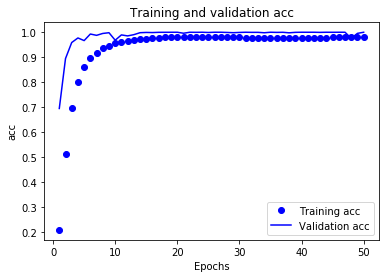

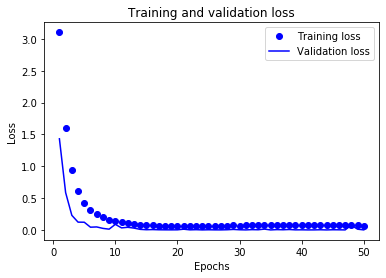

In [27]:
# Train the Model
history = model.fit_generator(epochs =EpochNum,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()


history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()
